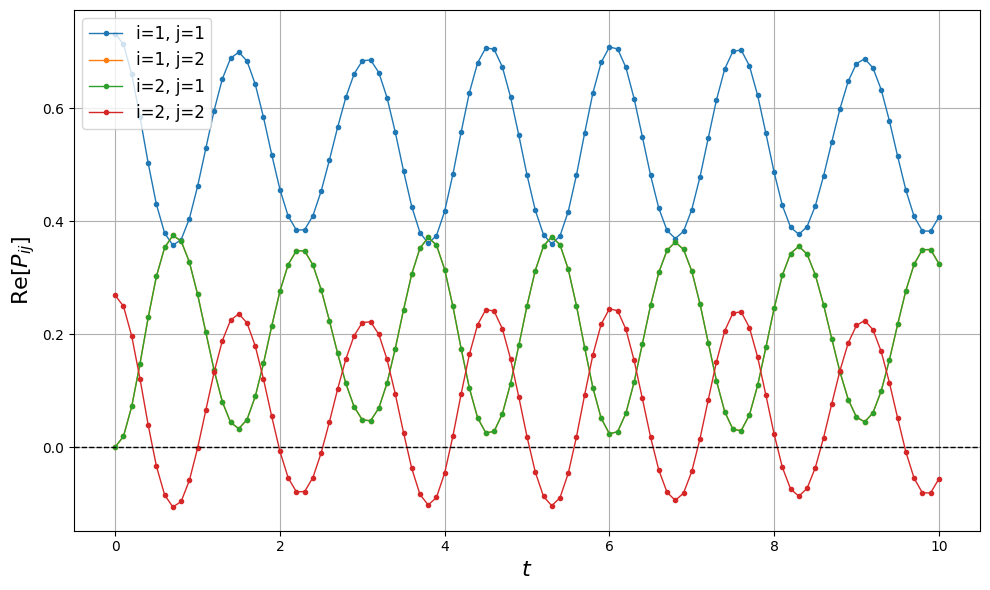

In [8]:
import numpy as np
from scipy.linalg import expm, eigh
from numpy import kron
import matplotlib.pyplot as plt

# ---------- Pauli matrices ----------
sx = np.array([[0, 1], [1, 0]], dtype=complex)
sy = np.array([[0, -1j], [1j, 0]], dtype=complex)
sz = np.array([[1, 0], [0, -1]], dtype=complex)
id2 = np.eye(2, dtype=complex)

# ---------- Kronecker embedding ----------
def embed(op, site, N):
    """Embed single-site operator op at position site (1-indexed)."""
    ops = [op if i == site else id2 for i in range(1, N+1)]
    O = ops[0]
    for k in range(1, N):
        O = kron(O, ops[k])
    return O

# ---------- TFIM Hamiltonian ----------
def TFIM(N, J, hz, hx):
    Hxx = np.zeros((2**N, 2**N), dtype=complex)
    Hz  = np.zeros((2**N, 2**N), dtype=complex)
    Hx  = np.zeros((2**N, 2**N), dtype=complex)

    # nearest neighbor XX interactions (open boundary)
    for i in range(1, N):
        Hxx += embed(sx, i, N) @ embed(sx, i+1, N)

    # fields
    for i in range(1, N+1):
        Hz += embed(sz, i, N)
        Hx += embed(sx, i, N)

    H = -J*Hxx - hz*Hz - hx*Hx
    return H, Hxx, Hz, Hx

# ---------- Parameters ----------
L = 4
N = L
J = 1
hz = 1
hx = 1

# Hamiltonian
H, Hxx, Hz, Hx = TFIM(N, J, hz, hx)

# ---------- Ground state ----------
eigvals, eigvecs = eigh(H)
ground_state = eigvecs[:, np.argmin(eigvals)]
S0 = ground_state

# ---------- Z-basis projectors ----------
zu = np.array([[1], [0]], dtype=complex)
zd = np.array([[0], [1]], dtype=complex)

Pzu = zu @ zu.conj().T
Pzd = zd @ zd.conj().T

def PZu(i): return embed(Pzu, i, N)
def PZd(i): return embed(Pzd, i, N)

# ---------- Operators ----------
V1 = PZu(1)
V2 = PZd(1)
W1 = PZu(1)
W2 = PZd(1)

# ---------- Time evolution ----------
T1, T2, dt = 0, 10, 0.1
tt = np.arange(T1, T2+dt, dt)

plt.figure(figsize=(10,6))

# Loop over i,j
for i in [1,2]:
    for j in [1,2]:
        if i==1 and j==1:
            V, W = V1, W1
        elif i==1 and j==2:
            V, W = V1, W2
        elif i==2 and j==1:
            V, W = V2, W1
        elif i==2 and j==2:
            V, W = V2, W2

        P_t = np.zeros(len(tt), dtype=float)

        for ti, t in enumerate(tt):
            U = expm(-1j * H * t)
            Vt = U.conj().T @ V @ U
            P_t[ti] = np.real(S0.conj().T @ Vt @ W @ S0)

        plt.plot(tt, P_t, '-o', markersize=3, linewidth=1, label=f"i={i}, j={j}")

# ---------- Plot formatting ----------
plt.axhline(0, color='k', linestyle='--', linewidth=1)
plt.xlabel(r"$t$", fontsize=16)
plt.ylabel(r"$\mathrm{Re}[P_{ij}]$", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()
